In [1]:
### addtiional info: https://www.gpxz.io/blog/gpx-file-to-pandas
#### https://towardsdatascience.com/parsing-fitness-tracker-data-with-python-a59e7dc17418

import gpxpy
import gpxpy.gpx
import geopy.distance
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from typing import Dict, Union
from datetime import datetime
from numpy_ext import rolling_apply
import numpy as np
import folium
import bs4
import requests
import ast
from io import StringIO
from csv import writer 

# Apply the default theme
sns.set_theme()

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
# Load gpx
gpx_path = '2022-10-22.gpx'
with open(gpx_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
track = gpx.tracks[0]

In [3]:
# create df, faster to create in csv in memory and then import csv

output = StringIO()
csv_writer = writer(output)

COLUMN_NAMES = ['latitude', 'longitude', 'elevation', 'time','speed_in_meters', 'heart_rate', ]
NAMESPACES = {'garmin_tpe': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}
    
try:
    segment = gpx.tracks[0].segments[0]  # Assuming we know that there is only one track and one segment
    df = pd.DataFrame(columns=COLUMN_NAMES)
    for point_idx, point in enumerate(segment.points):

        try:
            elem = point.extensions[0]
            hea = (int(elem.find('garmin_tpe:hr', NAMESPACES).text))
        except:
            hea = 0

        row = [point.latitude,
                             point.longitude,
                             point.elevation,
                             point.time,
                             segment.get_speed(point_idx),
                             hea]
        csv_writer.writerow(row)


except Exception as e: 
    print(e)

output.seek(0) # we need to get back to the start of the BytesIO
df = pd.read_csv(output, header=None, names=COLUMN_NAMES)

In [4]:
# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()
df['cumulative_miles'] = 0.000621371 * df['cumulative_distance']
df['time']= pd.to_datetime(df['time'])
df['cumulative_time'] = df['time']-df['time'].min()
df['cumulative_time'] =df['cumulative_time'] / np.timedelta64(1, 'm')

In [5]:
# the below uses the speed embedded in the data, calling it realspeed

ser = pd.array([0], dtype=float)

for x in range(0,len(df)-1):
    speed = segment.get_speed(x)
    ser = np.append(ser,[speed])

df['speed_in_meters'] = pd.Series(ser)
df['realspeed'] = df['speed_in_meters'] * 2.23694 # convert to mph
df['rolling_realspeed'] = df['realspeed'].rolling(10).mean() # using rolling average to smooth out


In [6]:
# get summary info
print("Activity Name:", track.name)
print("Min Elevation (ft):", "%.2f" % round(gpx.get_elevation_extremes()[0]*3.28084, 2))
print("Max Elevation (ft):", "%.2f" % round(gpx.get_elevation_extremes()[1]*3.28084, 2))
print("Moving Time (min):", "%.2f" % round(segment.get_moving_data()[0]/60, 2))
print("Stopped Time (min):", "%.2f" % round(segment.get_moving_data()[1]/60, 2))
print("Moving Distance (miles):", "%.2f" % round(segment.get_moving_data()[2]*0.000621371, 2))
print("Stopped Distance (miles):", "%.2f" % round(segment.get_moving_data()[3]*0.00062137, 2))
print("Max Speed (mph):", "%.2f" % round(df['rolling_realspeed'].max(), 2))
print("Avg Speed (mph):", "%.2f" % round(df['rolling_realspeed'].mean(), 2))
print("Max HR:", "%.2f" % round(df['heart_rate'].max(), 2))
print("Avg HR:", "%.2f" % round(df['heart_rate'].mean(), 2))

Activity Name: Lunch Ride
Min Elevation (ft): 1.64
Max Elevation (ft): 170.60
Moving Time (min): 203.08
Stopped Time (min): 6.55
Moving Distance (miles): 49.53
Stopped Distance (miles): 0.04
Max Speed (mph): 22.72
Avg Speed (mph): 15.19
Max HR: 178.00
Avg HR: 137.40


<Figure size 960x480 with 0 Axes>

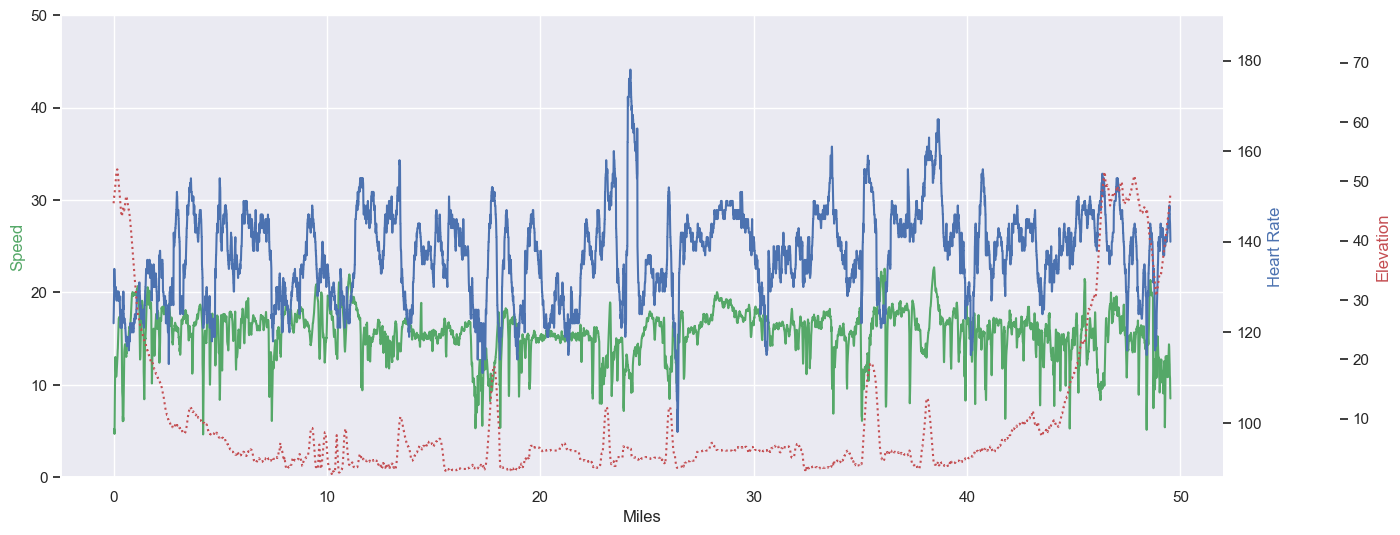

In [7]:
# graph speed

figure(figsize=(12, 6), dpi=80)

x = df.cumulative_miles
y1 = df.rolling_realspeed
y2 = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.1))

ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax3.plot(x, y3, 'r:')

ax1.set_xlabel('Miles')
ax1.set_ylabel('Speed', color='g')
ax2.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')

ax2.grid(False)
ax3.grid(False)

ax1.set_ylim(0,50)
ax2.set_ylim(df['heart_rate'].min()-10,190)
ax3.set_ylim(gpx.get_elevation_extremes()[0]/5,gpx.get_elevation_extremes()[1]*1.5)

plt.show()

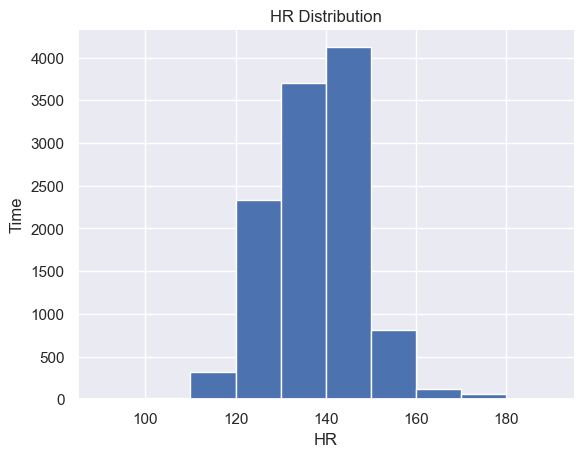

In [8]:
# the histogram of the data
n, bins, patches = plt.hist(df['heart_rate'], 10, range=(90,190))

plt.xlabel('HR')
plt.ylabel('Time')
plt.title('HR Distribution')
plt.show()

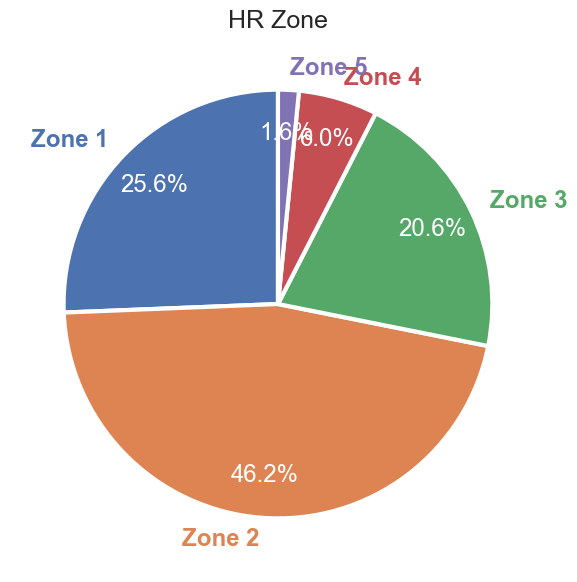

In [9]:
HR_zone_bins = [0, 131, 144, 151, 160, 200] # based off max hr
#HR_zone_bins = [0, 108, 129, 139, 159, 200] # based off LTHR
hr_count, division = np.histogram(df['heart_rate'], bins = HR_zone_bins)
hr_count = pd.DataFrame(hr_count)
x = hr_count[0]

labels = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5']

fig, ax = plt.subplots(figsize=(6, 6))

patches, texts, pcts = ax.pie(
    x, labels=labels, pctdistance=0.8, # controls distance from center of %
    autopct='%.1f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90)
# For each wedge, set the corresponding text label color to the wedge's
# face color.
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)
ax.set_title('HR Zone', fontsize=18)

plt.tight_layout()


In [10]:
hrdf = pd.DataFrame([labels,x]).T
hrdf[2] = hrdf[1]/hrdf[1].sum()*100
hrdf = hrdf.rename({0: 'Zone', 1: 'Minutes',2: 'Percent', }, axis='columns')
hrdf['Minutes'] = hrdf['Minutes']/60
hrdf

,Zone,Minutes,Percent
0,Zone 1,49.1,25.635225
1,Zone 2,88.533333,46.22346
2,Zone 3,39.466667,20.605639
3,Zone 4,11.433333,5.96937
4,Zone 5,3.0,1.566307


<Figure size 960x480 with 0 Axes>

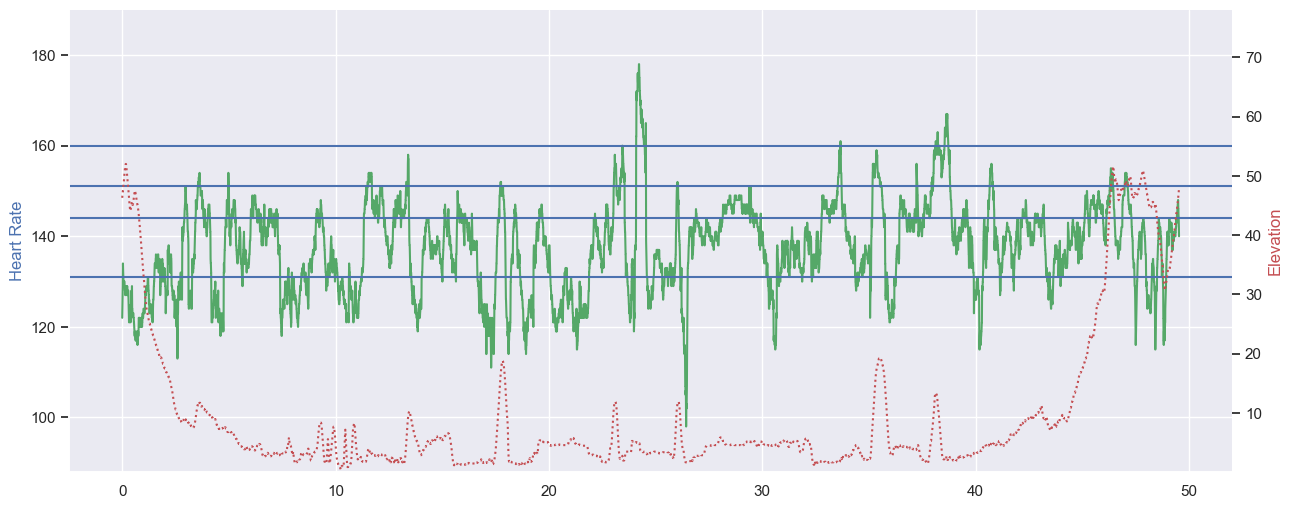

In [11]:
# Plot HR zones
figure(figsize=(12, 6), dpi=80)

x = df.cumulative_miles
y = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax3 = ax1.twinx()
ax1.plot(x, y, 'g-')
ax3.plot(x, y3, 'r:')

ax1.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')
ax1.set_ylim(df['heart_rate'].min()-10,190)
ax3.set_ylim(gpx.get_elevation_extremes()[0]/5,gpx.get_elevation_extremes()[1]*1.5)

ax3.grid(False)

ax1.axhline(y=HR_zone_bins[1]) # plot zone lines
ax1.axhline(y=HR_zone_bins[2])
ax1.axhline(y=HR_zone_bins[3])
ax1.axhline(y=HR_zone_bins[4])

plt.show()

In [12]:
lat = str(df['latitude'][0])[0:7]
lon = str(df['longitude'][0])[0:8]
date = df['time'][0].strftime('%Y-%m-%d')

print(lat,lon,date)

40.6719 -73.9619 2022-10-22


In [13]:
# scrape weather for time of activity

headers = {'User-Agent': 'Opera/9.80 (Windows NT 6.1; Win64; x64; Edition Next) Presto/2.12.388 Version/12.15',}
url = "https://darksky.net/details/%s,%s/%s/us12/en" % (lat,lon,date)
res = requests.get(url, headers=headers)
soup = bs4.BeautifulSoup(res.text, 'html.parser')

In [14]:
dtime = df['time'][0]
dtimestamp = str(round(dtime.timestamp()))
print("Integer timestamp of first data point: ", dtimestamp)

Integer timestamp of first data point:  1666457192


In [15]:
# pull temp from soup using above timestamp

all_scripts = soup.find_all('script')
jsn = all_scripts[1].text[16:]
jsn = jsn.split(dtimestamp[0:5])[1]
jsn = "{" + jsn.split('visibility')[0][6:-2] + "}"

jsn = ast.literal_eval(jsn)
print("Weather Summary:", jsn.get("summary"))
print("Temperature:", jsn.get("temperature"))
print("Feels Like:", jsn.get("apparentTemperature"))
print("Humidity:", jsn.get("humidity"))
print("Windspeed:", jsn.get("windSpeed"))
print("Precip Intensity:", jsn.get("precipIntensity"))

Weather Summary: Clear
Temperature: 52.75
Feels Like: 52.75
Humidity: 0.74
Windspeed: 6.74
Precip Intensity: 0


In [16]:
# add map

route_map = folium.Map(
    location=[lat, lon],
    zoom_start=13,
    tiles='CartoDBPositron',
    width=1024,
    height=600
)

coordinates = [tuple(x) for x in df[['latitude', 'longitude']].to_numpy()]
folium.PolyLine(coordinates, weight=3).add_to(route_map)

display(route_map)

<Figure size 960x480 with 0 Axes>

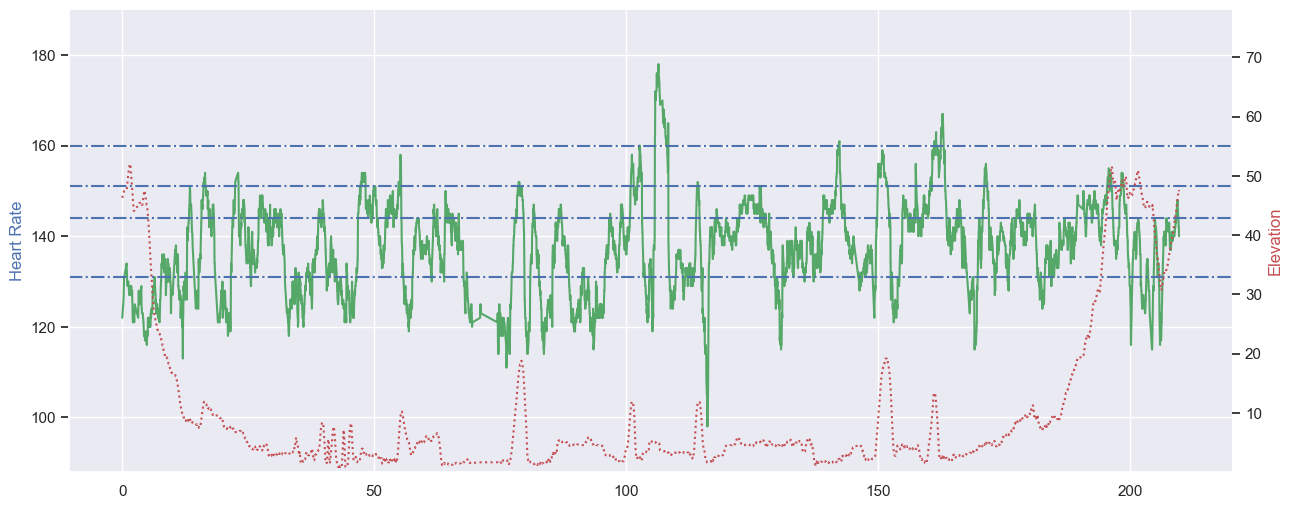

In [17]:
# Plot HR zones on time axis
figure(figsize=(12, 6), dpi=80)

x = df.cumulative_time
y = df.heart_rate
y3 = df.elevation

fig, ax1 = plt.subplots()
fig.set_size_inches(15,6)

ax3 = ax1.twinx()
ax1.plot(x, y, 'g-')
ax3.plot(x, y3, 'r:')

ax1.set_ylabel('Heart Rate', color='b')
ax3.set_ylabel('Elevation', color='r')
ax1.set_ylim(df['heart_rate'].min()-10,190)
ax3.set_ylim(gpx.get_elevation_extremes()[0]/5,gpx.get_elevation_extremes()[1]*1.5)

ax3.grid(False)

ax1.axhline(y=HR_zone_bins[1], linestyle="-.") # plot zone lines
ax1.axhline(y=HR_zone_bins[2], linestyle="-.")
ax1.axhline(y=HR_zone_bins[3], linestyle="-.")
ax1.axhline(y=HR_zone_bins[4], linestyle="-.")
#ax1.axhline(y=170, ) 

#plt.xlim([24, 26]) # use to zoom in to specific time segment
plt.show()